# Introduction:
> The below project is build over the European soccer database to investigate the dataset
 and answer the below posed questions.
 The Dataset used here was imported from [Kaggle](https://www.kaggle.com/datasets/hugomathien/soccer)

# Questions:
* What are the top 4 teams in each season
* who is the champion of each season
* who are the top 10 players of the time of our dataset
* what makes a perfect player


* importing needed libraries
* opne connection to sqlite DB

In [6]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# Connecting to SQLLite DB and gathering data

In [7]:
"""
Load Data from Sqlite DB to pandas DF
Args:
	(str) query - the query string which should be used to retreive the dataset
returns:
	df - pandas dataframe contains the exact data that returned from the SQL query
"""
def load_data(query):
	connection = sqlite3.connect("database.sqlite")
	cursor = connection.cursor()
	cursor.execute(query)
	names = [x[0] for x in cursor.description]
	rows = cursor.fetchall()
	df = pd.DataFrame(rows, columns=names)
	connection.close()
	return df

In [8]:
query = '''SELECT 	C.name country,L.name league,season,stage,date,
			(SELECT team_long_name FROM Team T WHERE M.home_team_api_id = T.team_api_id) home_team,
			(SELECT team_long_name FROM Team T WHERE M.away_team_api_id = T.team_api_id) away_team,
			home_team_goal,away_team_goal
	FROM Match M, Team T, Country C, League L
	WHERE 1 = 1
	AND T.team_api_id = M.home_team_api_id
	AND C.id = M.country_id
	AND L.id = M.league_id
	ORDER BY date,stage;'''
df = load_data(query)

# Data warngling

In [9]:
df.head()
df.isnull().sum().sum()
df.duplicated().sum()
df.dtypes
df.shape

(25979, 9)

# Cleaning Data


In [10]:
# as we found some null values those records will be dropped.
df.dropna(axis=0, inplace=True)
df.shape

(25979, 9)

# New Feature Engineering

## Adding new columns for points earned by each team for each match

In [11]:
df['goal_difference'] = df['home_team_goal'] - df['away_team_goal']
# df['home_team_points'] = np.zeros((df.shape[0],1), dtype=int)
# df['away_team_points'] = np.zeros((df.shape[0],1), dtype=int)
df['home_team_points'] = df['goal_difference'].apply(lambda x: 3 if x > 0 else (1 if x == 0 else 0))
df['away_team_points'] = df['goal_difference'].apply(lambda x: 3 if x < 0 else (1 if x == 0 else 0))

# Exploratory Data Analysis

## Calculating the aggregated points for each team per season

In [12]:
df.head()
home_points = df.groupby(['country', 'season', 'home_team'])['home_team_points'].sum()
away_points = df.groupby(['country', 'season', 'away_team'])['away_team_points'].sum()
combined_points = home_points.add(away_points)
combined_df = pd.DataFrame(combined_points, columns=['points'])
combined_df.reset_index(['country','home_team','season'], inplace=True)
combined_df.rename(columns={'home_team': 'team'}, inplace=True)

### Building our analysis here on the premier league as it's the most competitive league in Europe
#### Let's get the top four teams of each season in the premier league

In [13]:
max_points = combined_df.query('country == "England"').groupby('season').points.nlargest(4)
top_four = pd.DataFrame()
# champions = pd.DataFrame()
for s, points in max_points.index:
    top_four = top_four.append(combined_df.iloc[points,:], ignore_index=True)
top_four[['season', 'team', 'points']]

,season,team,points
0,2008/2009,Manchester United,90.0
1,2008/2009,Liverpool,86.0
2,2008/2009,Chelsea,83.0
3,2008/2009,Arsenal,72.0
4,2009/2010,Chelsea,86.0
5,2009/2010,Manchester United,85.0
6,2009/2010,Arsenal,75.0
7,2009/2010,Tottenham Hotspur,70.0
8,2010/2011,Manchester United,80.0
9,2010/2011,Chelsea,71.0


# Conclusion

### Let's figure out:
### how many each team appeared in the top four teams?

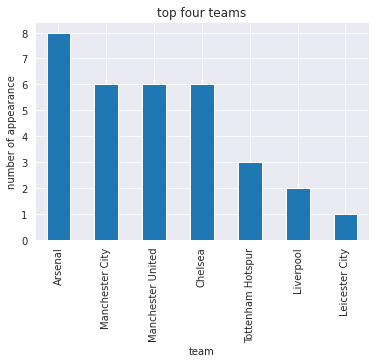

In [14]:
top_four['team'].value_counts().plot(kind='bar')
plt.title('top four teams')
plt.xlabel('team')
plt.ylabel('number of appearance');

## Now Let's see who is the champion of each season

In [15]:
top_four.groupby(['season'], sort=False)['points'].max()
idx = top_four.groupby(['season'])['points'].transform(max) == top_four['points'] 
champions = top_four[idx][['season','team','points']]
champions

,season,team,points
0,2008/2009,Manchester United,90.0
4,2009/2010,Chelsea,86.0
8,2010/2011,Manchester United,80.0
12,2011/2012,Manchester City,89.0
13,2011/2012,Manchester United,89.0
16,2012/2013,Manchester United,89.0
20,2013/2014,Manchester City,86.0
24,2014/2015,Chelsea,87.0
28,2015/2016,Leicester City,81.0


## Here we found that in 2011/2012 season both MCI and MNU had the same points
### to specify the winner we should calculated the goal difference
### What's the goal difference between MCI and MNU in 2011/2012 season?

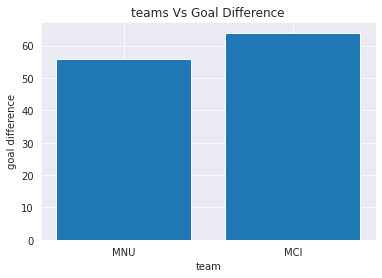

In [16]:
goals_to_MNU = df.query('home_team == "Manchester United" and season =="2011/2012"').groupby('season').home_team_goal.sum() + df.query('away_team == "Manchester United" and season =="2011/2012"').groupby('season').away_team_goal.sum()
goals_to_MCI = df.query('home_team == "Manchester City" and season =="2011/2012"').groupby('season').home_team_goal.sum() + df.query('away_team == "Manchester City" and season =="2011/2012"').groupby('season').away_team_goal.sum()
goals_against_MNU = df.query('away_team == "Manchester United" and season =="2011/2012"').groupby('season').home_team_goal.sum() + df.query('home_team == "Manchester United" and season =="2011/2012"').groupby('season').away_team_goal.sum()
goasl_against_MCI = df.query('away_team == "Manchester City" and season =="2011/2012"').groupby('season').home_team_goal.sum() + df.query('home_team == "Manchester City" and season =="2011/2012"').groupby('season').away_team_goal.sum()
MNU_goal_diff = goals_to_MNU - goals_against_MNU
MCI_goal_diff = goals_to_MCI - goasl_against_MCI
locations = [1, 2]
heights = [MNU_goal_diff[0], MCI_goal_diff[0]]
labels = ['MNU', 'MCI']
plt.bar(locations, heights, tick_label=labels)
plt.title('teams Vs Goal Difference');
champions
plt.xlabel('team')
plt.ylabel('goal difference');

> ##### as we notice that the goal difference is greater in MCI case, that's how they won 2011/2012 premier league season

### Let's now see: 
#### how many times each team won the premier league?

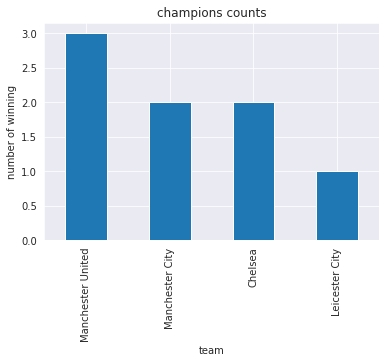

In [17]:
MNU_drop = champions[(champions['season'] == "2011/2012") & (champions['team'] == "Manchester United")].index
MCI_drop = champions.query('season == "2011/2012" and team == "Manchester City"').index
if MCI_goal_diff[0] > MNU_goal_diff[0]:
    champions.drop(MNU_drop, inplace=True)
else:
    champions.drop(MCI_drop, inplace=True)
champions['team'].value_counts().plot(kind='bar')
plt.title('champions counts')
plt.xlabel('team')
plt.ylabel('number of winning');

## we can notice that the most four teams enhancing durint the period of our dataset are:
* Manchester United
* Manchester City
* Chelsea
* Leicester City

# Limitations of Matches/Teams analysis
> I only build this analysis on the permier league. but, the exact the same analysis could be used for any other league analysis

# Analyazing the Player Table

## Gathering Data

In [18]:
query = '''SELECT player_name,birthday,weight,height,date,
	   overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
FROM Player AS P, Player_Attributes AS PA
WHERE P.player_api_id  = PA.player_api_id
'''
df = load_data(query)

## Data warngling

In [19]:
df.isnull().sum()
df.duplicated().sum()
df.dtypes
df.shape
df.head()

,player_name,birthday,weight,height,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,Aaron Appindangoye,1992-02-29 00:00:00,187,182.88,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,Aaron Appindangoye,1992-02-29 00:00:00,187,182.88,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,Aaron Appindangoye,1992-02-29 00:00:00,187,182.88,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,Aaron Appindangoye,1992-02-29 00:00:00,187,182.88,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,Aaron Appindangoye,1992-02-29 00:00:00,187,182.88,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


## Clean the Dataset

In [20]:
df.dropna()
df.drop_duplicates()
# getting the date column in the correct date Data type
df['date'] = pd.to_datetime(df['date'])
df.head()
df.shape

(183978, 43)

# Exploratory Data Analysis

## Let's figure out what makes a perfect player

#### first: Let's get the top 10 players according to the overall_rating and the mean of their relative attribute


In [21]:
top_players = df.groupby('player_name').overall_rating.mean().sort_values(ascending=False).head(10)
record = pd.DataFrame()
for player in top_players.index:
    record = record.append(df[df['player_name']==player], ignore_index=False)
record.columns
top = record.groupby('player_name')['overall_rating',
       'potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'].mean()
top

/home/elieba/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_name,,,,,,,,,,,,,,,,,,,,,
Andres Iniesta,88.320000,90.560000,83.720000,72.680000,55.320000,93.880000,74.000000,90.080000,80.000000,69.280000,...,92.920000,71.120000,58.240000,59.680000,56.000000,6.760000,14.720000,26.040000,14.520000,10.000000
Arjen Robben,87.840000,88.600000,82.480000,82.160000,51.560000,84.520000,84.480000,92.640000,84.800000,83.120000,...,82.400000,81.480000,26.240000,24.480000,25.240000,9.280000,10.680000,26.360000,8.760000,16.320000
Cristiano Ronaldo,91.280000,93.480000,83.880000,91.120000,85.520000,82.280000,85.560000,92.640000,88.000000,81.640000,...,80.680000,83.600000,22.120000,30.840000,23.000000,7.480000,12.960000,28.440000,15.160000,12.760000
Franck Ribery,88.458333,89.916667,85.166667,77.750000,48.541667,87.791667,82.041667,92.916667,86.833333,81.750000,...,86.958333,81.500000,18.708333,25.083333,26.000000,13.333333,8.541667,22.833333,9.500000,11.708333
Iker Casillas,86.954545,88.227273,16.136364,14.454545,19.454545,21.000000,13.136364,19.590909,16.727273,16.681818,...,49.000000,43.090909,14.772727,14.772727,11.727273,89.863636,82.045455,69.409091,84.409091,90.954545
Lionel Messi,92.192308,95.230769,83.346154,92.230769,69.269231,88.807692,87.538462,96.461538,87.692308,84.115385,...,90.269231,80.153846,18.769231,21.846154,20.115385,6.461538,12.653846,29.461538,15.076923,10.615385
Philipp Lahm,86.733333,87.533333,85.400000,43.266667,62.700000,87.233333,66.000000,81.366667,77.000000,57.500000,...,82.766667,72.233333,85.700000,87.466667,94.366667,10.733333,13.433333,16.266667,15.066667,7.600000
Wayne Rooney,87.222222,87.944444,78.472222,87.861111,78.583333,83.138889,88.694444,82.694444,83.500000,79.861111,...,84.166667,82.333333,30.750000,51.833333,37.777778,10.138889,12.000000,21.861111,9.527778,8.694444
Xavi Hernandez,87.636364,88.363636,86.090909,73.590909,54.727273,95.181818,67.545455,82.363636,84.363636,86.681818,...,95.681818,78.227273,55.863636,64.545455,62.272727,5.727273,16.136364,30.227273,8.363636,11.409091


#### Let's now establish a correlation matrix between the overall_rating and the other relative attributes, to answer the below question:
#### What makes a perfect player?

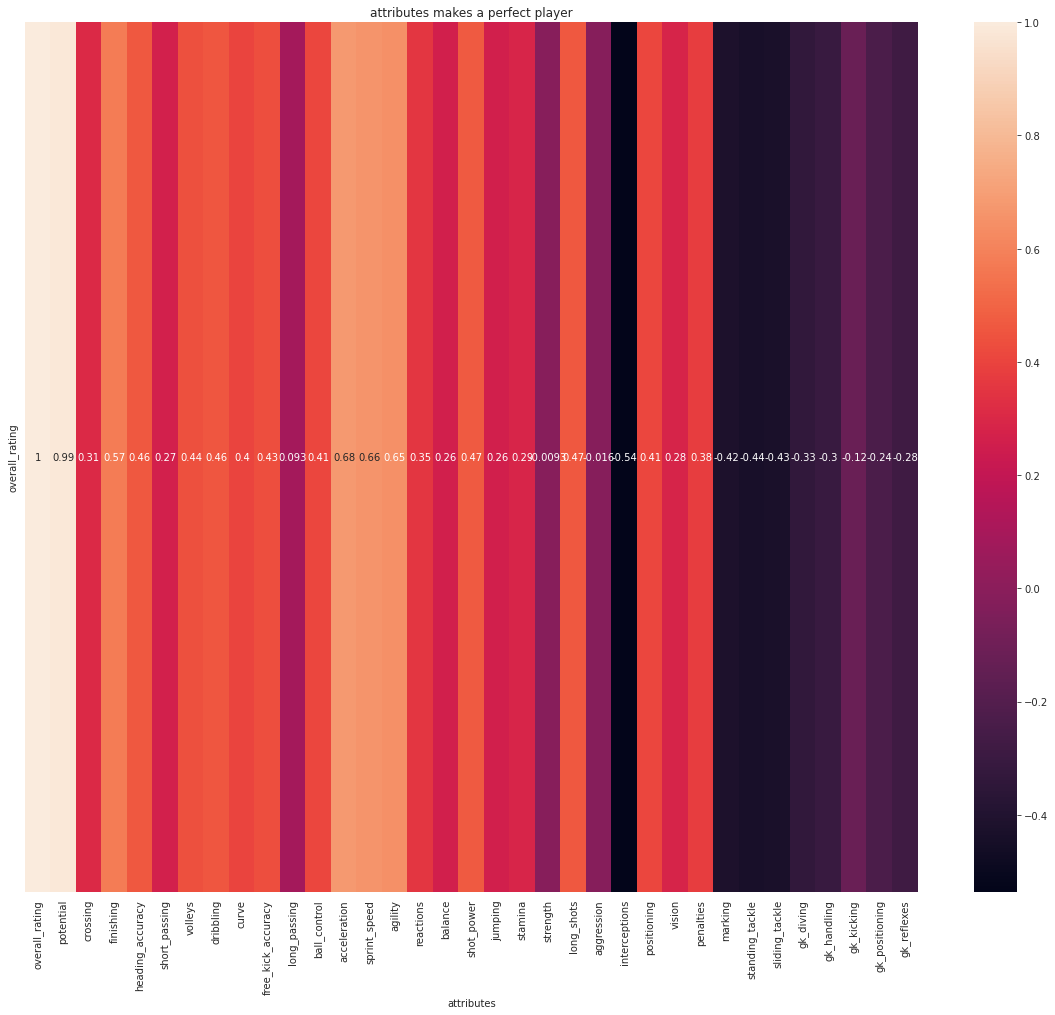

In [22]:
def draw_correlation():
    correlation_matrix = top.corr()[0:1]
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix,annot=True)
    plt.title('attributes makes a perfect player')
    plt.xlabel('attributes')
draw_correlation()

### for better analysis we can exclude Iker Casillas and the columns related to goal keeping from our analysis and draw our correlation matrix again
> ## being a goal keeper he would represent outlier in our dataset
#### as we notice that the goal keeper attributes negatively correlated with the overall rating which is not true for a goal keeper

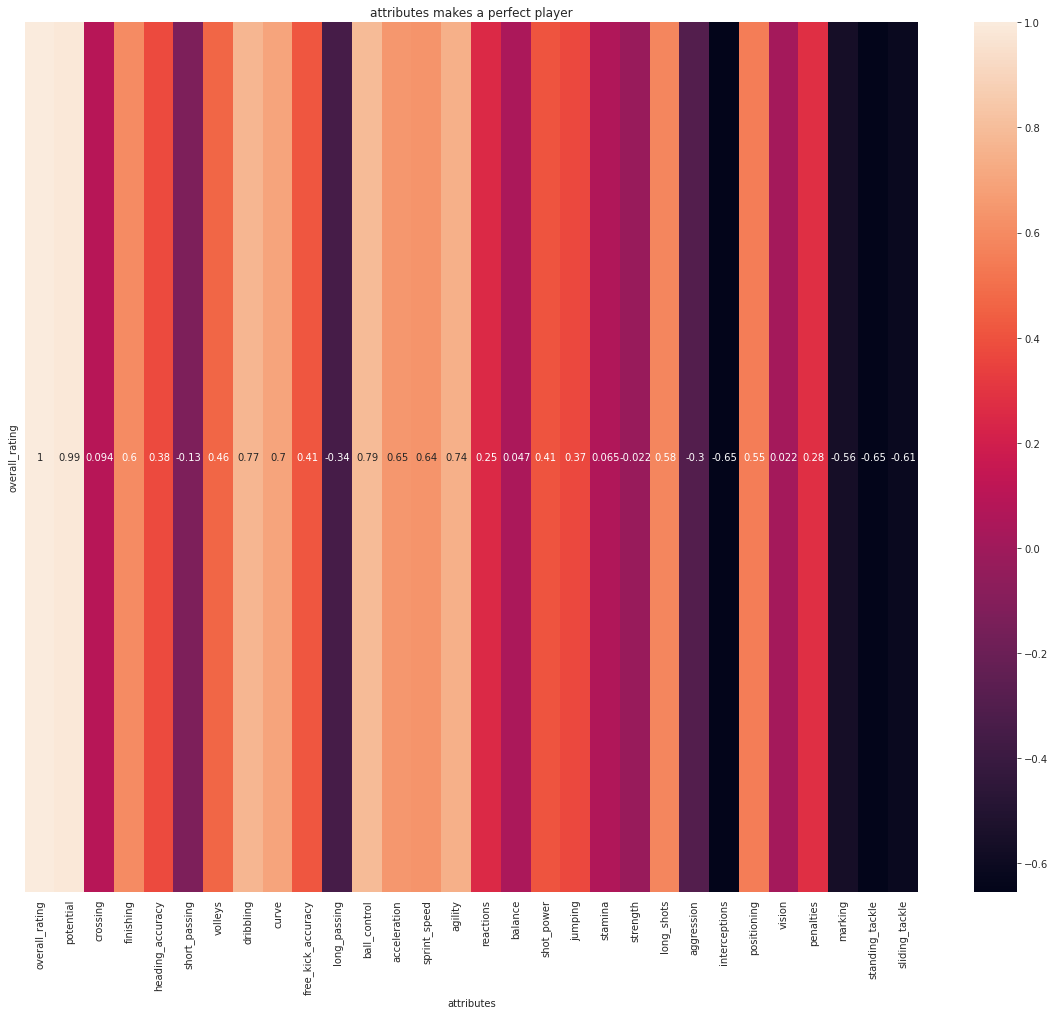

In [23]:
top.drop("Iker Casillas", axis=0, inplace=True)
top.drop(columns=['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],inplace=True)
draw_correlation()

# Conclusion

>   The above heatmap shows us the attributes correlation with overall_rating from the most positive to the most negative attribute we can also print them with correlation value as the below cell

## Now we have the attributes that can make a perfect player
### by showing the correlation from the most positive to the most negative

In [24]:

top.corr()[0:1].unstack().sort_values(ascending=False)

overall_rating      overall_rating    1.000000
potential           overall_rating    0.986883
ball_control        overall_rating    0.788954
dribbling           overall_rating    0.769039
agility             overall_rating    0.742838
curve               overall_rating    0.700646
acceleration        overall_rating    0.650422
sprint_speed        overall_rating    0.637548
finishing           overall_rating    0.601488
long_shots          overall_rating    0.580676
positioning         overall_rating    0.550857
volleys             overall_rating    0.463584
free_kick_accuracy  overall_rating    0.411951
shot_power          overall_rating    0.410595
heading_accuracy    overall_rating    0.379050
jumping             overall_rating    0.366926
penalties           overall_rating    0.277970
reactions           overall_rating    0.251215
crossing            overall_rating    0.093591
stamina             overall_rating    0.065301
balance             overall_rating    0.046515
vision       

# Limitations

> The above analysis is build over players not goal keepers, but we can use the same analysis with goal keepers related attributes to see what makes a perfect goal keeper.